LLM BASED REVIEW HANDLING WORKFLOW

In [9]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from tqdm import tqdm
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGoogleGenerativeAI(
    model = 'gemini-2.0-flash'
)

In [12]:
class SentimentSchema(BaseModel):
    sentiment : Literal['positive', 'negative'] = Field(description='Sentiment of the review')

structured_model = llm.with_structured_output(SentimentSchema)

In [15]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

structured_model2 = llm.with_structured_output(DiagnosisSchema)

In [14]:
class ReviewState(TypedDict):
    
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

In [27]:
def find_sentiment(state: ReviewState) -> dict:
    review = state['review']

    prompt = f"""find sentiment for the following review \n {review}"""
    output = structured_model.invoke(prompt).sentiment

    return {'sentiment': output}


def check_sentiment(state: ReviewState) -> Literal['run_diagnosis', 'positive_response']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    

def run_diagnosis(state: ReviewState) -> dict:  

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
    """
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}


def positive_response(state: ReviewState) -> dict:

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""
    
    response = llm.invoke(prompt).content

    return {'response': response}


def negative_response(state: ReviewState) -> dict:

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message.
    """
    response = llm.invoke(prompt).content

    return {'response': response}

In [28]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)
graph.add_node('positive_response', positive_response)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)
graph.add_edge('positive_response', END)

workflow = graph.compile()

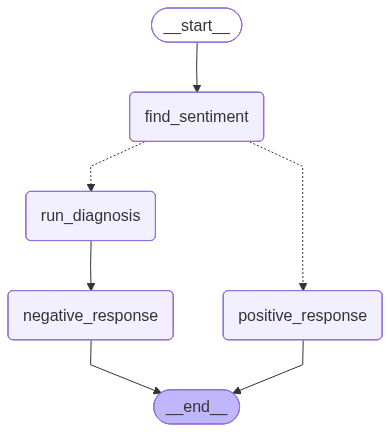

In [29]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [30]:
intial_state={
    'review': "I've been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': "I've been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.",
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': 'Okay, I understand you\'re experiencing a bug and it\'s causing you frustration. I know how annoying and disruptive that can be, especially when it\'s marked as a high urgency issue. I\'m here to help get this resolved for you as quickly as possible.\n\nFirst, please know that I understand your frustration. We strive for a seamless experience and it\'s disappointing when things don\'t work as they should.\n\nTo help me get to the bottom of this and find the best solution, could you provide me with a little more information? Specifically:\n\n*   **What were you doing when the bug occurred?**\n*   **What is the exact error message 